#### I. Referencias consultadas

Algebra lineal
+ [Distintas formas de invertir matrices en Julia](https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)

Libería Gridap
+ [Domain Contributions](https://github.com/gridap/Gridap.jl/blob/ba78d8d34207b318dab7251617bdc310f6be26fc/src/CellData/DomainContributions.jl#L2)
+ [MultiField](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/MultiField)
+ [FESpaces](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/FESpaces)
+ [Tutorials](https://gridap.github.io/Tutorials/dev/)
+ [Community](https://gitter.im/Gridap-jl/community)

Libreria Arpack
+ [API Arpack.eigs](https://arpack.julialinearalgebra.org/stable/api/)
+ [Arpack](https://docs.juliahub.com/Arpack/X5VZL/0.4.0/#lib-itereigen-1)
+ [Eigen value problems](https://doc.freefem.org/models/eigen-value-problems.html)

Libreria SLEPc
+ [GridapPETSc](https://github.com/gridap/GridapPETSc.jl)
+ [Julia wrapper for SLEPc library](https://discourse.julialang.org/t/julia-wrapper-for-slepc-library/54910)
+ [Parallel Julia wrapper for SLEPc library](https://juliahub.com/ui/Packages/SlepcWrap/S3PC8/0.1.2)

Teoría
+ [Gram-Schmidt Procedure](https://tlienart.github.io/posts/2021/06/25-gram-schmidt/)

# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el problema de autovalores

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [11]:
include("../modules/module_schrodinger_equation_testing_02.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.1000 (coupling)
x₁=0.0000 x₂=2.0000 y₁=0.0000 y₂=2.0000 (QHO origin position)


## 2. Creamos propiedades de la grilla

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [32]:
grid_type="simple_line";                            # tipo de grilla
# ΔxH=1.0/1500.0;                                      # tamaño del elento 1D
ΔxH=1.0/1000.0;

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.029767s, CPU 0.023829s)
Info    : 50001 nodes 50002 elements
Info    : Writing '../models/simple_line_01.msh'...
Info    : Done writing '../models/simple_line_01.msh'
Info    : Reading '../models/simple_line_01.msh'...
Info    : 3 entities
Info    : 50001 nodes
Info    : 50002 elements
Info    : Done reading '../models/simple_line_01.msh'


Creamos una función para obtener los puntos discretos de la grilla (valuados) y un vector de dichos puntos, lo cual será útil para graficar los resultados o realizar cálculos específicos

In [33]:
function space_coord(dom,Δx)
    x=[dom[1]+abs(dom[2]-dom[1])*Δx*i for i in 1:convert(Int,1.0/Δx)];
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/ΔxH)];
    return x,pts;
end

space_coord (generic function with 1 method)

In [4]:
x,pts=space_coord(dom_1D,ΔxH);

## 3. Primer método

La idea acá es resolver el problema de autovalores para los hamiltonianos $\hat {h}(x)$ y $\hat {H}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales

In [5]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);

aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D);

Construimos el problema de autovalores, con parámetros específicos de resolución

In [6]:
nevₕ=40; # debe ser múltiplo de 2
# probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0);
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0);

Resolvermos el problema, para obtener autovalores y autoestados

In [7]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [8]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,convert(Int32,probₕ_1D.nev/2));

for i in 1:2:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    fₕre_1D,fₕim_1D=fₕ_1D;
    ϕₕreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(fₕre_1D+im*fₕim_1D,Uₕreim_1D);
end

Creamos una función que arroja un vector de valores, donde cada elemento será el resultado de la norma de un autoestado de $\hat {h}_{x_0=0}(x)$

In [9]:
function normalization_eigenstates_1D(ϕ,TrialSpace,dΩ)
    nom_vec=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        nom_vec[i]=norm_L2(ϕ[i],dΩ)
    end
    return nom_vec;
end

normalization_eigenstates_1D (generic function with 1 method)

Verificamos la normalización de los autoestados, para ello usando la función anterior debemos obtener resultados cercanos a la unidad

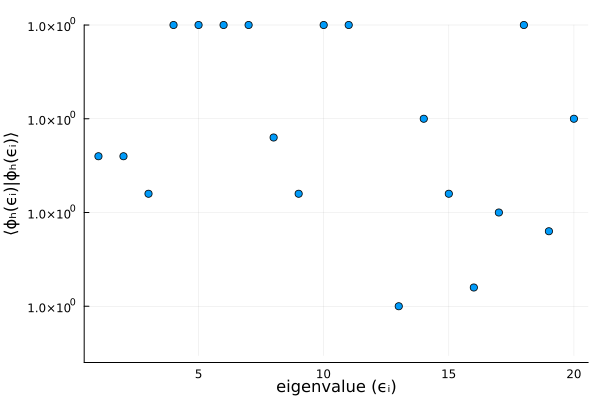

In [17]:
plotting=false
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

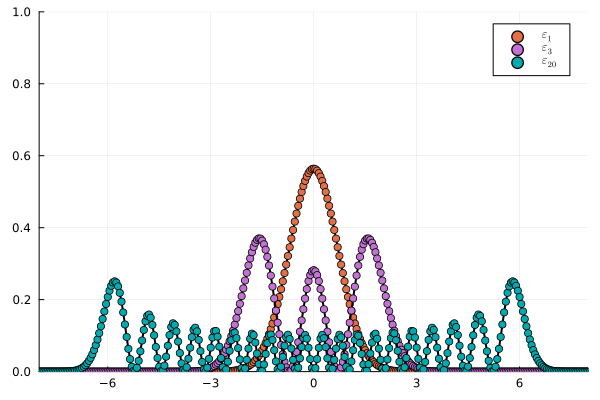

In [23]:
plotting=false
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,3,20]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,1),xlim=(-8,8))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,1),xlim=(-8,8))
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_vs_position_eigenproblem_1D.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

In [10]:
ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

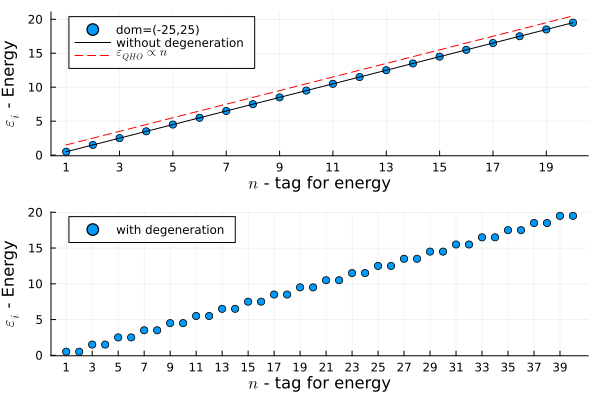

In [29]:
plotting=false
if plotting
    plot1=scatter([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!([i for i in 1:nevₕ/2],(ħ*ω).*([i for i in 1:nevₕ/2].+0.5),label="\$\\epsilon_{QHO} \\propto n\$",lc=:"red",lw=1,ls=:dash);
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot2,path_plots*"enegies_eigenproblem_1D.pdf");
    display(plot3)
end

### 3.2. Resolvemos problema de autovalores para $\hat {H}(x)$

Definimos espacios Test y Trial reales y creamos un `MultiFieldFESpace()` para el sistema $4 \times 4$

In [41]:
V₁reH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁reH_1D=TrialFESpace(V₁reH_1D,dirichlet_values_1D);
V₁imH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁imH_1D=TrialFESpace(V₁imH_1D,dirichlet_values_1D);

V₂reH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂reH_1D=TrialFESpace(V₂reH_1D,dirichlet_values_1D);
V₂imH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂imH_1D=TrialFESpace(V₂imH_1D,dirichlet_values_1D);

UH_1D=MultiFieldFESpace([U₁reH_1D,U₁imH_1D,U₂reH_1D,U₂imH_1D]);
VH_1D=MultiFieldFESpace([V₁reH_1D,V₁imH_1D,V₂reH_1D,V₂imH_1D]);

aH_1D,bH_1D=bilineal_forms_eigenprob_H_ReImParts(pH,qH₁,qH₂,rH,sH,dΩ_1D);

Definimos el problema con parámetros específicos de resolución

In [42]:
nevH=40; # debe ser multiplo de 2
probH_1D=EigenProblem(aH_1D,bH_1D,VH_1D,UH_1D;nev=nevH,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0);

Resolvemos el problema de autovalores

In [43]:
ϵH_1D,ϕH_1D=solve(probH_1D);

Ahora unimos parte real e imaginaria para formar autoestados complejos

In [44]:
V₁reimH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁reimH_1D=TrialFESpace(V₁reimH_1D,dirichlet_values_1D);
V₂reimH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂reimH_1D=TrialFESpace(V₂reimH_1D,dirichlet_values_1D);
UHreim_1D=MultiFieldFESpace([U₁reimH_1D,U₂reimH_1D]);
VHreim_1D=MultiFieldFESpace([V₁reimH_1D,V₂reimH_1D]);

# ϕHreim_1D=Vector{CellField}(undef,convert(Int32,probH_1D.nev/4));
ϕHreim_1D=Vector{CellField}(undef,convert(Int32,probH_1D.nev/2));

# for i in 1:4:probH_1D.nev
for i in 1:2:probH_1D.nev
    fH_1D=interpolate_everywhere(ϕH_1D[i],probH_1D.trial);
    f₁Hre_1D,f₁Him_1D,f₂Hre_1D,f₂Him_1D=fH_1D;
    # ϕHreim_1D[convert(Int32,(i+3)/4)]=interpolate_everywhere([f₁Hre_1D+im*f₁Him_1D,f₂Hre_1D+im*f₂Him_1D],UHreim_1D);
    ϕHreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere([f₁Hre_1D+im*f₁Him_1D,f₂Hre_1D+im*f₂Him_1D],UHreim_1D);
end

Chequeamos normalización de los autoestados

In [38]:
function normalization_eigenstates_2D(ϕ,TrialSpace,dΩ)
    nom_vec₁₂=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        norm_ϕ¹ᵢ=norm_L2(ϕ¹ᵢ,dΩ)
        norm_ϕ²ᵢ=norm_L2(ϕ²ᵢ,dΩ)
        nom_vec₁₂[i]=norm_ϕ¹ᵢ+norm_ϕ²ᵢ
    end
    return nom_vec₁₂;
end

normalization_eigenstates_2D (generic function with 1 method)

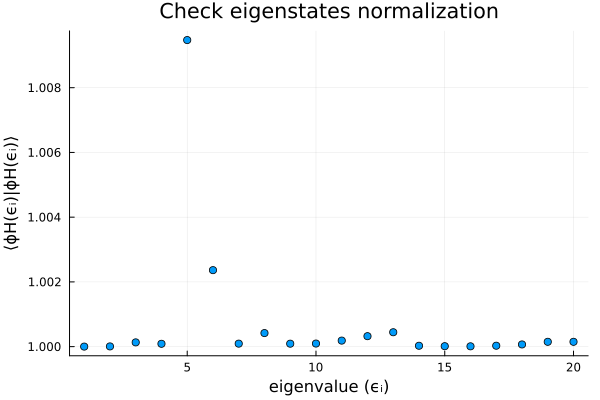

In [38]:
plotting=false
if plotting
    ϕHreim_1D_norm=normalization_eigenstates_2D(ϕHreim_1D,UHreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕHreim_1D)],ϕHreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕH(ϵᵢ)|ϕH(ϵᵢ)⟩")
    plot₁=plot!(title="Check eigenstates normalization")
    display(plot₁)
end

Chequeamos ortogonalidad entre autoestados

In [16]:
function OrthoCheck_2D(ϕ,TrialSpace,dΩ)
    nev=length(ϕ)
    OrthoVector=zeros(Float64,nev^2-nev);
    index=1
    for i in 1:nev
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        for j in 1:nev
            if (i ≠ j)
                ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
                ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
                OrthoVector[index]=abs(sum(∫(ϕ¹ⱼ'*ϕ¹ᵢ)*dΩ)+sum(∫(ϕ²ⱼ'*ϕ²ᵢ)*dΩ))
                index+=1
            end
        end
    end

    return OrthoVector;
end

OrthoCheck_2D (generic function with 1 method)

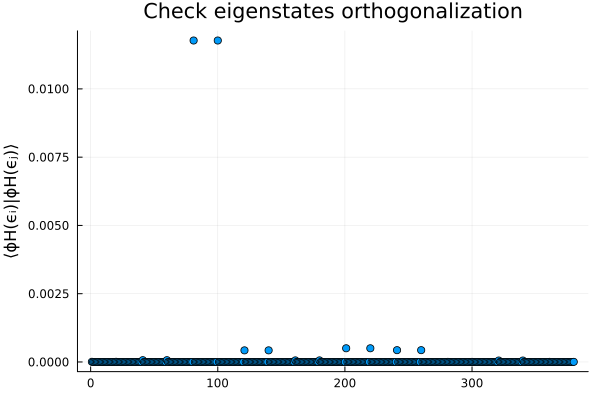

In [40]:
plotting=false
if plotting
    ϕHreim_1D_ortho=OrthoCheck_2D(ϕHreim_1D,UHreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!(ϕHreim_1D_ortho,label="")
    plot₁=plot!(xlabel="",ylabel="⟨ϕH(ϵᵢ)|ϕH(ϵⱼ)⟩")
    plot₁=plot!(title="Check eigenstates orthogonalization")
    display(plot₁)
end

Graficamos autoestados del hamiltoniano completo $\hat {H} (x)$

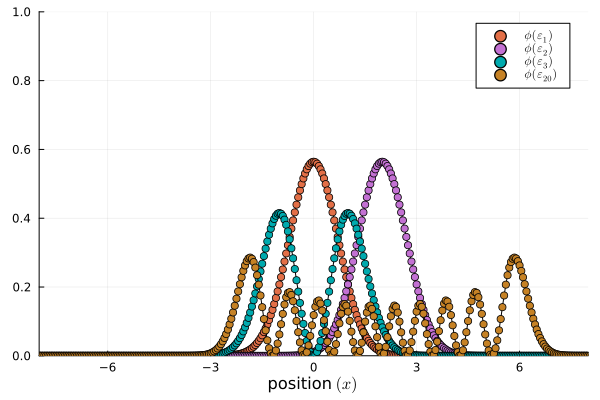

In [45]:
plt=plot();

    for i in [1,2,3,20]
        ρ₁Hreim_1D=real(conj(ϕHreim_1D[i][1].(pts)).*ϕHreim_1D[i][1].(pts))
        ρ₂Hreim_1D=real(conj(ϕHreim_1D[i][2].(pts)).*ϕHreim_1D[i][2].(pts))
        plot1=plot!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="",lw=1,lc=:"black")
        plot1=scatter!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="\$ \\phi(\\epsilon_{$(i)})\$",lw=2,ylim=(0,1),xlim=(-8,8))
    end

    plot1=plot!(xlabel="position \$(x)\$",ylabel="")

    plot3=plot(plot1);
    display(plot3);
    # savefig(plot3,path_plots*"density_vs_position_eigenproblem_1D.pdf");

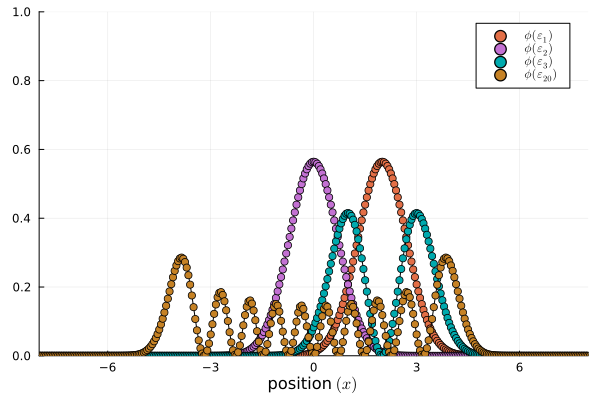

In [44]:
plotting=false
if plotting
    plt=plot();

    for i in [1,2,3,20]
        ρ₁Hreim_1D=real(conj(ϕHreim_1D[i][1].(pts)).*ϕHreim_1D[i][1].(pts))
        ρ₂Hreim_1D=real(conj(ϕHreim_1D[i][2].(pts)).*ϕHreim_1D[i][2].(pts))
        plot1=plot!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="",lw=1,lc=:"black")
        plot1=scatter!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="\$ \\phi(\\epsilon_{$(i)})\$",lw=2,ylim=(0,1),xlim=(-8,8))
    end

    plot1=plot!(xlabel="position \$(x)\$",ylabel="")

    plot3=plot(plot1);
    display(plot3);
    # savefig(plot3,path_plots*"density_vs_position_eigenproblem_1D.pdf");
end

Y hacemos lo mismo con los autovalores

In [46]:
# ϵHre_1D=ϵH_1D[1:4:end];
# n=[i for i in 1:nevH/4];
ϵHre_1D=ϵH_1D[1:2:end];
n=[i for i in 1:nevH/2];

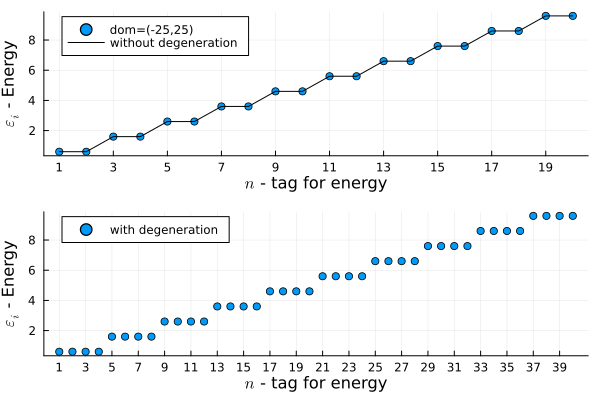

In [46]:
plotting=false
if plotting
    plot1=scatter(n,ϵHre_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot1=plot!(n,ϵHre_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevH],ϵH_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot2,path_plots*"enegies_eigenproblem_1D.pdf");
    display(plot3)
end

## 4. Segundo método (NO FUNCIONA)

La idea acá es resolver nuevamente el problema de autovalores para los hamiltonianos $\hat {h}(x)$ y $\hat {H}(x)$. Los espacios Test y Trial son complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados de forma conjunta. 

Si queremos resolver el problema en un espacio complejo, funciona todo bien para el problema de autovalores de $\hat {h}(x)$ pero no para el problema de autovalores de $\hat {H}(x)$

ESTO FUNCIONA

In [135]:
runcomplx=false;
if runcomplx
    Vₕcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕcomplx_1D=TrialFESpace(Vₕcomplx_1D,dirichlet_values_1D);
    aₕcomplx_1D,bₕcomplx_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);
    probₕcomplx_1D=EigenProblem(aₕcomplx_1D,bₕcomplx_1D,Uₕcomplx_1D,Vₕcomplx_1D;nev=20,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0);
    ϵₕcomplx_1D,ϕₕcomplx_1D=solve(probₕcomplx_1D);
end

In [136]:
runcomplx=false;
if runcomplx
    # espacio de pruebas y de soluciones para ψ₁
    V₁Hcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    U₁Hcomplx_1D=TrialFESpace(V₁Hcomplx_1D,dirichlet_values_1D);
    # espacio de pruebas y de soluciones para ψ₂
    V₂Hcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    U₂Hcomplx_1D=TrialFESpace(V₂Hcomplx_1D,dirichlet_values_1D);
    # creamos un campo de espacios
    UHcomplx_1D = MultiFieldFESpace([U₁Hcomplx_1D,U₂Hcomplx_1D]);
    VHcomplx_1D = MultiFieldFESpace([V₁Hcomplx_1D,V₂Hcomplx_1D]);

    aHcomplx_1D,bHcomplx_1D=bilineal_forms_eigenprob_H(pH,qH₁,qH₂,rH,sH,dΩ_1D);
end

ESTO NO FUNCIONA
Arroja el siguiente error
```
MethodError: Cannot `convert` an object of type 
  Gridap.Fields.ArrayBlock{Array{ComplexF64,1},1} to an object of type 
  Gridap.Fields.ArrayBlock{Array{Float64,1},1}
```

In [134]:
# nevH=20;probHcomplx_1D=EigenProblem(aHcomplx_1D,bHcomplx_1D,UHcomplx_1D,VHcomplx_1D;nev=nevH,which=:LI,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0)

In [19]:
# ϵHcomplx_1D,ϕHcomplx_1D=solve(probHcomplx_1D);

## 5. Resolución de la parte temporal de la ecuación de Schrödinger (evolución)

Y ahora evolucionamos conocidos los autoestados del hamiltoniano del sistema $\hat {H}(x)$. Para esto primeramente debemos encontrar cómo se descompone el estado inicial en la base de autoestados de $\hat {H}(x)$.

### 5.1 Funciones útiles para el caso en que $\gamma=0$ (sin acoplamiento)

Creamos una función para recolectar datos del problema de autovalores. Construimos matriz donde cada columna corresponde a un autoestado de $\hat {H}(x)$ y donde cada fila corresponde a dicho autoestado valuado en un punto de la grilla

In [18]:
function eigendata_multifield(ϵ,ϕ,pts,TrialSpace)

    dim_pts=length(pts);
    nev=length(ϕ);

    Heigenvecs₁=zeros(ComplexF64,dim_pts,nev);
    Heigenvecs₂=copy(Heigenvecs₁);
    for i in 1:nev
        fH=interpolate_everywhere(ϕ[i],TrialSpace);
        f₁H,f₂H,=fH;
        Heigenvecs₁[:,i]=f₁H.(pts);
        Heigenvecs₂[:,i]=f₂H.(pts);
    end

    Heigenvals=copy(ϵ);
    return Heigenvals,Heigenvecs₁,Heigenvecs₂;
end

eigendata_multifield (generic function with 1 method)

Funciones para determinar coeficientes que permiten escribir la condición inicial como combinación lineal de autoestados

In [19]:
function CoeffInitCond₁(𝛹₀,pts,Heigenvecs₁,Heigenvecs₂)

    dimrows=convert(Int32,2*length(Heigenvecs₁[:,1]))
    dimcol=length(Heigenvecs₁[1,:])

    Heigenvecs₁₂=zeros(ComplexF64,dimrows,dimcol); # creamos matriz de componentes de eigenvectors
    Heigenvecs₁₂[1:length(Heigenvecs₁[:,1]),:]=Heigenvecs₁
    Heigenvecs₁₂[convert(Int32,length(Heigenvecs₁[:,1])+1):end,:]=Heigenvecs₂

    𝛹¹₀,𝛹²₀=𝛹₀;

    InnerProdBC=zeros(ComplexF64,dimrows); # creamos vector de componentes del vector estado inicial
    InnerProdBC[1:length(Heigenvecs₁[:,1])]=𝛹¹₀.(pts);
    InnerProdBC[convert(Int32,length(Heigenvecs₁[:,1])+1):end]=𝛹²₀.(pts);

    # 1er método para invertir matrices
    adjcoeffvec₁₂=conj(InnerProdBC)\Heigenvecs₁₂; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    # 2do método para invertir matrices (MENOS PRECISO https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)
    # adjcoeffvec₁₂=pinv(Heigenvecs₁₂)*conj(InnerProdBC);

    return adjoint(adjcoeffvec₁₂);
end

function CoeffInitCond₂(𝛹¹₀,𝛹²₀,Heigenvecs₁,Heigenvecs₂)

    dimrows=convert(Int32,2*length(Heigenvecs₁[:,1]))
    dimcol=length(Heigenvecs₁[1,:])

    Heigenvecs₁₂=zeros(ComplexF64,dimrows,dimcol); # creamos matriz de componentes de eigenvectors
    Heigenvecs₁₂[1:length(Heigenvecs₁[:,1]),:]=Heigenvecs₁
    Heigenvecs₁₂[convert(Int32,length(Heigenvecs₁[:,1])+1):end,:]=Heigenvecs₂
    𝛹¹₀
    InnerProdBC=zeros(ComplexF64,dimrows); # creamos vector de componentes del vector estado inicial
    InnerProdBC[1:length(Heigenvecs₁[:,1])]=𝛹¹₀;
    InnerProdBC[convert(Int32,length(Heigenvecs₁[:,1])+1):end]=𝛹²₀;

    # 1er método para invertir matrices
    adjcoeffvec₁₂=conj(InnerProdBC)\Heigenvecs₁₂; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    # 2do método para invertir matrices (MENOS PRECISO https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)
    # adjcoeffvec₁₂=pinv(Heigenvecs₁₂)*conj(InnerProdBC);

    return adjoint(adjcoeffvec₁₂);
end

CoeffInitCond₂ (generic function with 1 method)

### 5.2 Funciones útiles para el caso en que $\gamma \neq 0$ (con acoplamiento)

In [20]:
# Inner product in L₂
function InnerProduct(ϕ₁vec,ϕ₂vec,dΩ)
    return sum(∫(ϕ₁vec'*ϕ₂vec)*dΩ);
    #=
    es necesario calcular la función sum() porque el argumento
    es de tipo DomainContribution() y debemos sumar en cada punto
    de la grilla según la interpolación definida.
    Para más infor ver:
        https://github.com/gridap/Gridap.jl/blob/ba78d8d34207b318dab7251617bdc310f6be26fc/src/CellData/DomainContributions.jl#L2
    =#
end

InnerProduct (generic function with 1 method)

Funciones para determinar coeficientes que permiten escribir la condición inicial como combinación lineal de autoestados

In [21]:
function CoeffInitCond₁v₂(𝛹₀,TrialSpace,ϕ,dΩ) # MALA PERFORMANCE (MEDIDO EN TIEMPO DE CPU)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InnerProdEigenvecs=zeros(ComplexF64,dim*4,dim); # creamos matriz de componentes de eigenvectors
    InnerProdBC=zeros(ComplexF64,dim*4); # creamos vector de componentes del vector estado inicial

    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ¹ᵢ,𝛹¹₀,dΩ)
        for j in 1:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ¹ᵢ,ϕ¹ⱼ,dΩ)
        end
    end

    for i in dim+1:2*dim
        ϕᵢ=interpolate_everywhere(ϕ[i-dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ¹ᵢ,𝛹²₀,dΩ)
        for j in 1:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ¹ᵢ,ϕ²ⱼ,dΩ)
        end
    end

    for i in 2*dim+1:3*dim
        ϕᵢ=interpolate_everywhere(ϕ[i-2*dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ²ᵢ,𝛹¹₀,dΩ)
        for j in 1:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ²ᵢ,ϕ¹ⱼ,dΩ)
        end
    end

    for i in 3*dim+1:4*dim
        ϕᵢ=interpolate_everywhere(ϕ[i-3*dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ²ᵢ,𝛹²₀,dΩ)
        for j in 1:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ²ᵢ,ϕ²ⱼ,dΩ)
        end
    end

    coeffvec₁₂=InnerProdBC\InnerProdEigenvecs; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    return coeffvec₁₂;
end

function CoeffInitCond₁v₂Optimized(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InnerProdEigenvecs=zeros(ComplexF64,dim*4,dim); # creamos matriz de componentes de eigenvectors
    InnerProdBC=zeros(ComplexF64,dim*4); # creamos vector de componentes del vector estado inicial

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ¹ᵢ,𝛹¹₀,dΩ)
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ¹ᵢ,ϕ¹ⱼ,dΩ)
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j,i]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    # cuarta submatriz n✖n y subvector n✖1
    for i in (3*dim+1):4*dim
        ϕᵢ=interpolate_everywhere(ϕ[i-3*dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ²ᵢ,𝛹²₀,dΩ)
        for j in (i-3*dim):dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ²ᵢ,ϕ²ⱼ,dΩ)
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j+3*dim,i-3*dim]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    # segunda submatriz n✖n y subvector n✖1
    for i in (dim+1):(2*dim)
        ϕᵢ=interpolate_everywhere(ϕ[i-dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ¹ᵢ,𝛹²₀,dΩ)
        for j in 1:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ¹ᵢ,ϕ²ⱼ,dΩ)
        end
    end

    # tercera submatriz n✖n y subvector n✖1
    for i in (2*dim+1):(3*dim)
        ϕᵢ=interpolate_everywhere(ϕ[i-2*dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ²ᵢ,𝛹¹₀,dΩ)
    end
    # optimización por simetría
    InnerProdEigenvecs[(2*dim+1):(3*dim),1:dim]=adjoint(InnerProdEigenvecs[(dim+1):(2*dim),1:dim])

    coeffvec₁₂=InnerProdBC\InnerProdEigenvecs; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    return coeffvec₁₂;
end

function CoeffInitCond₁v₂Optimizedv₂(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InnerProdEigenvecs=zeros(ComplexF64,dim*2,dim); # creamos matriz de componentes de eigenvectors
    InnerProdBC=zeros(ComplexF64,dim*2); # creamos vector de componentes del vector estado inicial

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ¹ᵢ,𝛹¹₀,dΩ)
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ¹ᵢ,ϕ¹ⱼ,dΩ)
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j,i]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    # segunda submatriz n✖n y subvector n✖1
    for i in (dim+1):(2*dim)
        ϕᵢ=interpolate_everywhere(ϕ[i-dim],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=InnerProduct(ϕ²ᵢ,𝛹²₀,dΩ)
        for j in (i-dim):dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=InnerProduct(ϕ²ᵢ,ϕ²ⱼ,dΩ)
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j,i]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    coeffvec₁₂=InnerProdBC\InnerProdEigenvecs; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    return coeffvec₁₂;
end

function CoeffInitCond₁v₂Optimizedv₃(𝛹₀,TrialSpace,ϕ,dΩ)
    dim=length(ϕ)

    InvInnerProdEigenvecs₁=zeros(ComplexF64,dim,dim);   # sub-matriz de inversas de productos internos entre autoestados (1ra componente)
    InvInnerProdEigenvecs₂=zeros(ComplexF64,dim,dim);   # sub-matriz de inversas de productos internos entre autoestados (2da componente)
    InnerProdBC₁=zeros(ComplexF64,dim);                 # sub-vector de productos internos entre autoestados y estado inicial (1ra componente)
    InnerProdBC₂=zeros(ComplexF64,dim);                 # sub-vector de productos internos entre autoestados y estado inicial (2da componente)

    𝛹¹₀,𝛹²₀=𝛹₀;
    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC₁[i]=InnerProduct(ϕ¹ᵢ,𝛹¹₀,dΩ)
        InnerProdBC₂[i]=InnerProduct(ϕ²ᵢ,𝛹²₀,dΩ)
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InvInnerProdEigenvecs₁[i,j]=InnerProduct(ϕ¹ⱼ,ϕ¹ᵢ,dΩ)
            InvInnerProdEigenvecs₂[i,j]=InnerProduct(ϕ²ⱼ,ϕ²ᵢ,dΩ)
            if (i≠j) # optimización por simetría
                InvInnerProdEigenvecs₁[j,i]=conj(InvInnerProdEigenvecs₁[i,j])
                InvInnerProdEigenvecs₂[j,i]=conj(InvInnerProdEigenvecs₂[i,j])
            end
        end
    end
    # invertimos término a término
    InvInnerProdEigenvecs₁=inv.(InvInnerProdEigenvecs₁)
    InvInnerProdEigenvecs₂=inv.(InvInnerProdEigenvecs₂)

    coeffvec₁₂=zeros(ComplexF64,dim);
    aux₁=InvInnerProdEigenvecs₁*InnerProdBC₁
    aux₂=InvInnerProdEigenvecs₂*InnerProdBC₂
    @. coeffvec₁₂=aux₁+aux₂

    return coeffvec₁₂;
end

function CoeffInitCond₁v₂Optimizedv₄(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InvInnerProdEigenvecs=zeros(ComplexF64,dim,2*dim);  # matriz global de inversas de productos internos entre autoestados
    InnerProdBC=zeros(ComplexF64,2*dim);                # vector global de productos internos entre autoestados y estado inicial

    InvInnerProdEigenvecs₁=zeros(ComplexF64,dim,dim);   # sub-matriz de inversas de productos internos entre autoestados (1ra componente)
    InvInnerProdEigenvecs₂=zeros(ComplexF64,dim,dim);   # sub-matriz de inversas de productos internos entre autoestados (2da componente)
    InnerProdBC₁=zeros(ComplexF64,dim);                 # sub-vector de productos internos entre autoestados y estado inicial (1ra componente)
    InnerProdBC₂=zeros(ComplexF64,dim);                 # sub-vector de productos internos entre autoestados y estado inicial (2da componente)

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC₁[i]=InnerProduct(ϕ¹ᵢ,𝛹¹₀,dΩ)
        InnerProdBC₂[i]=InnerProduct(ϕ²ᵢ,𝛹²₀,dΩ)
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InvInnerProdEigenvecs₁[i,j]=InnerProduct(ϕ¹ⱼ,ϕ¹ᵢ,dΩ)
            InvInnerProdEigenvecs₂[i,j]=InnerProduct(ϕ²ⱼ,ϕ²ᵢ,dΩ)
            if (i≠j) # optimización por simetría
                InvInnerProdEigenvecs₁[j,i]=conj(InvInnerProdEigenvecs₁[i,j])
                InvInnerProdEigenvecs₂[j,i]=conj(InvInnerProdEigenvecs₂[i,j])
            end
        end
    end

    # invertimos término a término
    InvInnerProdEigenvecs₁=inv.(InvInnerProdEigenvecs₁)
    InvInnerProdEigenvecs₂=inv.(InvInnerProdEigenvecs₂)

    # ensamblamos matriz y vector globales
    InvInnerProdEigenvecs[1:dim,1:dim]=InvInnerProdEigenvecs₁
    InvInnerProdEigenvecs[1:dim,(dim+1):2*dim]=InvInnerProdEigenvecs₂
    InnerProdBC[1:dim]=InnerProdBC₁
    InnerProdBC[(dim+1):2*dim]=InnerProdBC₂

    coeffvec₁₂=InvInnerProdEigenvecs*InnerProdBC;

    return coeffvec₁₂;
end

function CoeffInitCond₁v₂Optimizedv₅(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InvInnerProdEigenvecs=zeros(ComplexF64,dim,dim);  # matriz global de inversas de productos internos entre autoestados
    InnerProdBC=zeros(ComplexF64,dim);                # vector global de productos internos entre autoestados y estado inicial

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        # InnerProdBC[i]=(sum(∫(ϕ¹ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹²₀)*dΩ))
        InnerProdBC[i]=(sum(∫(ϕ¹ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ¹ᵢ'*𝛹²₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹²₀)*dΩ))
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            # InvInnerProdEigenvecs[i,j]=(sum(∫(ϕ¹ⱼ'*ϕ¹ᵢ)*dΩ)+sum(∫(ϕ²ⱼ'*ϕ²ᵢ)*dΩ))
            InvInnerProdEigenvecs[i,j]=(sum(∫(ϕ¹ⱼ'*ϕ¹ᵢ)*dΩ)+sum(∫(ϕ¹ⱼ'*ϕ²ᵢ)*dΩ)+sum(∫(ϕ²ⱼ'*ϕ¹ᵢ)*dΩ)+sum(∫(ϕ²ⱼ'*ϕ²ᵢ)*dΩ))
            if (i≠j) # optimización por simetría
                InvInnerProdEigenvecs[j,i]=conj(InvInnerProdEigenvecs[i,j])
            end
        end
    end
    
    # invertimos término a término
    InvInnerProdEigenvecs=inv.(InvInnerProdEigenvecs)

    coeffvec₁₂=InvInnerProdEigenvecs*InnerProdBC;

    return coeffvec₁₂;
end


CoeffInitCond₁v₂Optimizedv₅ (generic function with 1 method)

In [27]:
function CoeffInitCond₁v₂Optimizedv₆(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InnerProdEigenvecs=zeros(ComplexF64,dim,dim);  # matriz global de inversas de productos internos entre autoestados
    InnerProdBC=zeros(ComplexF64,dim);                # vector global de productos internos entre autoestados y estado inicial

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=(sum(∫(ϕ¹ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹²₀)*dΩ))
        # InnerProdBC[i]=(sum(∫(ϕ¹ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ¹ᵢ'*𝛹²₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹²₀)*dΩ))
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=(sum(∫(ϕ¹ᵢ'*ϕ¹ⱼ)*dΩ)+sum(∫(ϕ²ᵢ'*ϕ²ⱼ)*dΩ))
            # InnerProdEigenvecs[i,j]=(sum(∫(ϕ¹ᵢ'*ϕ¹ⱼ)*dΩ)+sum(∫(ϕ¹ᵢ'*ϕ²ⱼ)*dΩ)+sum(∫(ϕ²ᵢ'*ϕ¹ⱼ)*dΩ)+sum(∫(ϕ²ᵢ'*ϕ²ⱼ)*dΩ))
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j,i]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    # x=A\b
    coeffvec₁₂=InnerProdEigenvecs\InnerProdBC;

    return coeffvec₁₂;
end

CoeffInitCond₁v₂Optimizedv₆ (generic function with 1 method)

### 5.3 Construimos el estado inicial

Acá definimos el estado fundamental del hamiltoniano $\hat {h}_{x_0=0}(x)$ como una función interpolable que podremos utilizar para construir la condicion inicial del sistema global, gobernado por $\hat {H}(x)$.

In [49]:
u₀ₕ_1D=interpolate_everywhere(ϕₕreim_1D[1],Uₕreim_1D);
interp_u₀ₕ_1D=Interpolable(u₀ₕ_1D);

Acá efectivamente construimos la condición inicial

In [50]:
type_BC=1;
if (type_BC==1)
    u₁0H_1D_v₁(x)=0.0;
    u₂0H_1D_v₁=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[2]);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₁,u₂0H_1D_v₁],UHreim_1D);
elseif (type_BC==2)
    u₁0H_1D_v₂=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[1]);
    u₂0H_1D_v₂(x)=0.0;
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₂,u₂0H_1D_v₂],UHreim_1D);
elseif (type_BC==3)
    u₁0H_1D_v₃=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[1]);
    u₂0H_1D_v₃=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[2]);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₃,u₂0H_1D_v₃],UHreim_1D);
end

MultiFieldFEFunction():
 num_cells: 50000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 8300845355590953863

Graficamos funciones densidad inicial (para el caso en que `type_BC=1`)

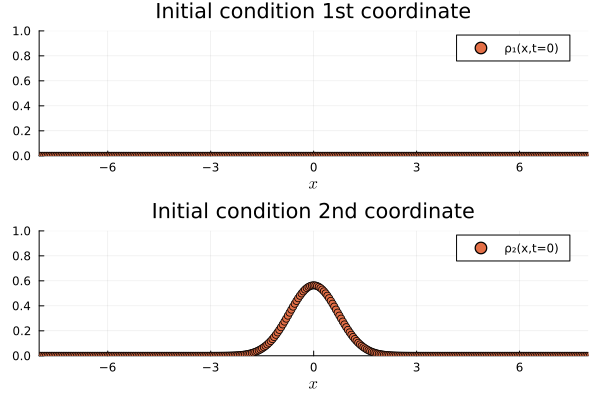

In [64]:
plotting=false
if plotting
    ρ¹₀H_1D=real(conj(u₀H_1D[1].(pts)).*u₀H_1D[1].(pts))
    ρ²₀H_1D=real(conj(u₀H_1D[2].(pts)).*u₀H_1D[2].(pts))

    plot1=plot(x,ρ¹₀H_1D,label="",lw=1,lc=:"black",ylim=(0,1),xlim=(-8,8))
    plot1=scatter!(x,ρ¹₀H_1D,label="ρ₁(x,t=0)",lw=2,ylim=(0,1),xlim=(-8,8),xlabel="\$x\$")
    plot1=plot!(title="Initial condition 1st coordinate")

    plot2=plot(x,ρ²₀H_1D,label="",lw=1,lc=:"black",ylim=(0,1),xlim=(-8,8))
    plot2=scatter!(x,ρ²₀H_1D,label="ρ₂(x,t=0)",lw=2,ylim=(0,1),xlim=(-8,8),xlabel="\$x\$")
    plot2=plot!(title="Initial condition 2nd coordinate")

    plot3=plot(plot1,plot2,layout=(2,1));
    display(plot3);
    savefig(plot3,path_plots*"density_vs_position_initialcondition_1D_01.pdf");
end

### 5.4 Evolución para cuando $\gamma = 0$ (without coupling)

In [89]:
Heigenvals,Heigenvecs₁,Heigenvecs₂=eigendata_multifield(ϵHre_1D,ϕHreim_1D,pts,UHreim_1D);

In [65]:
function evolution_schrodinger(Heigenvals,Heigenvecs₁,Heigenvecs₂,𝛹₀,pts,time_vec)

    dim_time=length(time_vec)
    dim_eigenval=length(Heigenvals)
    dim_position=length(Heigenvecs₁[:,1])

    𝛹₁ₓₜ=zeros(ComplexF64,dim_position,dim_time);
    𝛹₂ₓₜ=zeros(ComplexF64,dim_position,dim_time);

    coeffvec₁₂=CoeffInitCond₁(𝛹₀,pts,Heigenvecs₁,Heigenvecs₂);

    for i in 1:dim_time
        for j in 1:dim_eigenval
            for k in 1:dim_position
                𝛹₁ₓₜ[k,i]=𝛹₁ₓₜ[k,i]+coeffvec₁₂[j]*exp(-im*(1.0/ħ)*Heigenvals[j]*time_vec[i])*Heigenvecs₁[k,j]
                𝛹₂ₓₜ[k,i]=𝛹₂ₓₜ[k,i]+coeffvec₁₂[j]*exp(-im*(1.0/ħ)*Heigenvals[j]*time_vec[i])*Heigenvecs₂[k,j]
            end
        end
        coeffvec₁₂=CoeffInitCond₂(𝛹₁ₓₜ[:,i],𝛹₂ₓₜ[:,i],Heigenvecs₁,Heigenvecs₂);
    end

    return 𝛹₁ₓₜ,𝛹₂ₓₜ;
end

evolution_schrodinger (generic function with 1 method)

In [ ]:
time_vec=[(i-1)*1e-2 for i in 1:1];

In [ ]:
ψ₁t,ψ₂t=evolution_schrodinger(Heigenvals,Heigenvecs₁,Heigenvecs₂,u₀H_1D,pts,time_vec);

### 5.5 Evolución para cuando $\gamma \neq 0$ (with coupling)

In [24]:
function evolution_schrodinger_v₂(ϵ,ϕ,TrialSpace,𝛹₀,time_vec,dΩ)

    dim_time=length(time_vec)
    dim_eigenval=length(ϵ)

    # coeffvec₁₂=CoeffInitCond₁v₂(𝛹₀,TrialSpace,ϕ,dΩ) # muy ineficiente
    # coeffvec₁₂=CoeffInitCond₁v₂Optimized(𝛹₀,TrialSpace,ϕ,dΩ)
    # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₂(𝛹₀,TrialSpace,ϕ,dΩ)
    # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₃(𝛹₀,TrialSpace,ϕ,dΩ)
    # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₄(𝛹₀,TrialSpace,ϕ,dΩ)
    # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₅(𝛹₀,TrialSpace,ϕ,dΩ)
    coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₆(𝛹₀,TrialSpace,ϕ,dΩ)

    𝛹ₓₜ=Vector{CellField}(undef,dim_time);

    # inicializamos en cero el vector de onda
    ϕ₁=interpolate_everywhere(ϕ[1],TrialSpace);
    ϕ¹₁,ϕ²₁=ϕ₁;
    for i in 1:dim_time
        𝛹ₓₜ[i]=interpolate_everywhere([0.0*ϕ¹₁,0.0*ϕ²₁],TrialSpace)
    end

    for i in 1:dim_time
        for j in 1:dim_eigenval
            𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace)
            𝛹¹ₓₜⁱ,𝛹²ₓₜⁱ=𝛹ₓₜⁱ

            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ;
            
            factor=coeffvec₁₂[j]*exp(-im*(1.0/ħ)*ϵ[j]*time_vec[i])
            
            𝛹ₓₜ[i]=interpolate_everywhere([𝛹¹ₓₜⁱ+factor*ϕ¹ⱼ,𝛹²ₓₜⁱ+factor*ϕ²ⱼ],TrialSpace)
        end

        norm_switch=true
        if norm_switch
            Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,TrialSpace,dΩ)
            𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace)
            𝛹¹ₓₜⁱ,𝛹²ₓₜⁱ=𝛹ₓₜⁱ
            𝛹ₓₜ[i]=interpolate_everywhere([𝛹¹ₓₜⁱ/Norm𝛹ₓₜ[i],𝛹²ₓₜⁱ/Norm𝛹ₓₜ[i]],TrialSpace)
        end


        # coeffvec₁₂=CoeffInitCond₁v₂(𝛹ₓₜ[i],TrialSpace,ϕ,dΩ) # muy ineficiente
        # coeffvec₁₂=CoeffInitCond₁v₂Optimized(𝛹ₓₜ[i],TrialSpace,ϕ,dΩ)
        # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₂(𝛹ₓₜ[i],TrialSpace,ϕ,dΩ)
        # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₃(𝛹ₓₜ[i],TrialSpace,ϕ,dΩ)
        # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₄(𝛹₀,TrialSpace,ϕ,dΩ)
        # coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₅(𝛹₀,TrialSpace,ϕ,dΩ)
        coeffvec₁₂=CoeffInitCond₁v₂Optimizedv₆(𝛹₀,TrialSpace,ϕ,dΩ)
    end

    return 𝛹ₓₜ;
end

evolution_schrodinger_v₂ (generic function with 1 method)

In [47]:
time_vec=[(i-1) for i in 1:10];

In [51]:
𝛹ₓₜ=evolution_schrodinger_v₂(ϵHre_1D,ϕHreim_1D,UHreim_1D,u₀H_1D,time_vec,dΩ_1D);

## 8. Resultados obtenidos

### 8.1 Testeamos los métodos para $\gamma = 0$

Para el caso en que la segunda componente de $\psi_{0}$ corresponde a un autoestado de $\hat {h}_{x_{i}=0}$ y la primer componente de $\psi_{0}$ es trivialmente nula, esperamos que la primer componente no evolucione en absoluto y que la segunda componente evolucione como un estado coherente.

In [23]:
function density_prob(𝛹₁ₓₜ,𝛹₂ₓₜ)
    
    dim_space=length(𝛹₁ₓₜ[:,1])
    dim_time=length(𝛹₁ₓₜ[1,:])

    ρ₁ₓₜ=zeros(Float64,dim_space,dim_time);
    ρ₂ₓₜ=zeros(Float64,dim_space,dim_time);

    @. ρ₁ₓₜ=conj(𝛹₁ₓₜ)*𝛹₁ₓₜ
    @. ρ₂ₓₜ=conj(𝛹₂ₓₜ)*𝛹₂ₓₜ
    
    return ρ₁ₓₜ,ρ₂ₓₜ;
end

density_prob (generic function with 1 method)

In [24]:
ρ₁t,ρ₂t=density_prob(ψ₁t,ψ₂t);

([5.800405815620299e-34 5.800389706322538e-34 … 5.800111295795471e-34 5.800095467770281e-34; 2.014070013233178e-34 2.01406542632446e-34 … 2.0143739502592157e-34 2.014369410711419e-34; … ; 3.5475722341163643e-34 3.5475576977166587e-34 … 3.5435173556894328e-34 3.5435022809560333e-34; 0.0 0.0 … 0.0 0.0], [7.384392669357206e-36 7.384417351717147e-36 … 7.407619849087449e-36 7.407645545474023e-36; 2.507657460183705e-35 2.507641295159239e-35 … 2.5017570312832596e-35 2.5017404581092933e-35; … ; 3.842573443332929e-34 3.8425485459405853e-34 … 3.835780216096803e-34 3.835755788606644e-34; 0.0 0.0 … 0.0 0.0])

In [30]:
# anim₁ = @animate for i in 1:10:length(time_vec)
#     plot(x[:],real(ψ₁t[:,i].+ψ₂t[:,i]),label="Re{ψ(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(x[:],imag(ψ₁t[:,i].+ψ₂t[:,i]),label="Im{ψ(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(title="Schrödinger equation",xlabel="\$x\$",ylabel="\$ \\psi (x,t)\$")
# end

# anim₂ = @animate for i in 1:10:length(time_vec)
#     plot(x,real(ψ₁t[:,i]),label="Re{ψ₁(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(x,imag(ψ₁t[:,i]),label="Im{ψ₁(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(x,real(ψ₂t[:,i]),label="Re{ψ₂(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(x,imag(ψ₂t[:,i]),label="Im{ψ₂(x,t = $(round(time_vec[i]; digits=4)))}",ylim=(-1,1),xlim=(-8,8))
#     plot!(title="Schrödinger equation",xlabel="\$x\$",ylabel="\$ \\psi_{1,2}(x,t)\$")
# end

# display(gif(anim₁,fps=70))
# display(gif(anim₂,fps=70))

Plots.AnimatedGif("/tmp/jl_YPYBo3w7ol.gif")
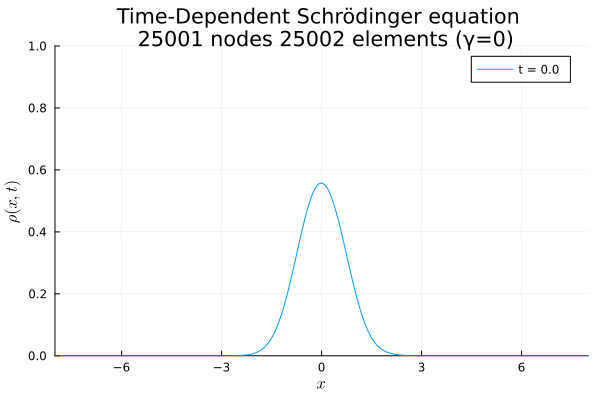

┌ Info: Saved animation to 
│   fn = /tmp/jl_YPYBo3w7ol.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_YJeR0ti5uV.gif")
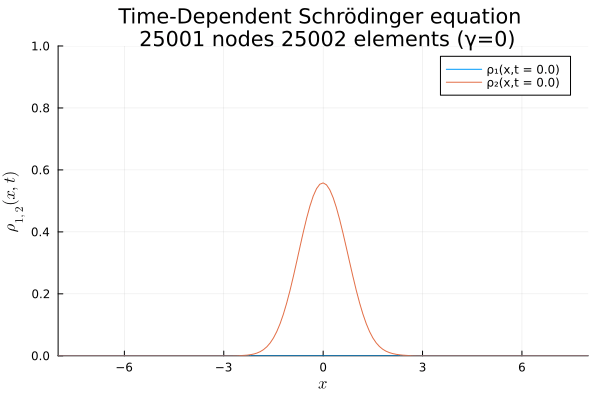

┌ Info: Saved animation to 
│   fn = /tmp/jl_YJeR0ti5uV.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


In [33]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    display(gif(anim₁,fps=70))
    display(gif(anim₂,fps=70))
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_01.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_02.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_02.gif")
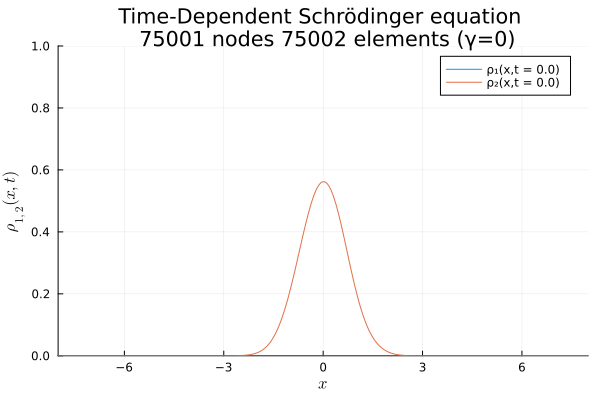

In [108]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 75001 nodes 75002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 75001 nodes 75002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    gif(anim₁, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_01.gif", fps = 70)
    gif(anim₂, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_02.gif", fps = 70)
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_03.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_04.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_04.gif")
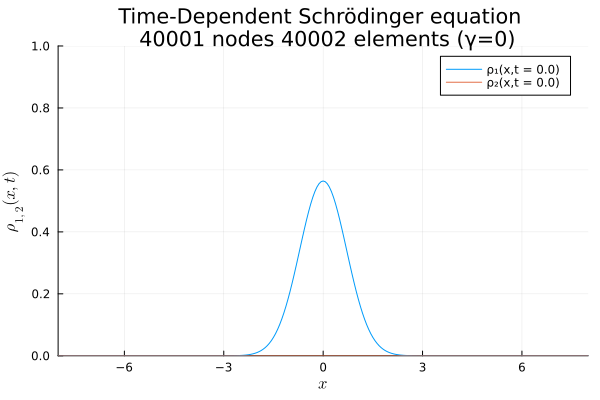

In [26]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 40001 nodes 40002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 40001 nodes 40002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    gif(anim₁, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_03.gif", fps = 70)
    gif(anim₂, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_04.gif", fps = 70)
end

### 8.2 Testeamos los métodos para $\gamma \neq 0$

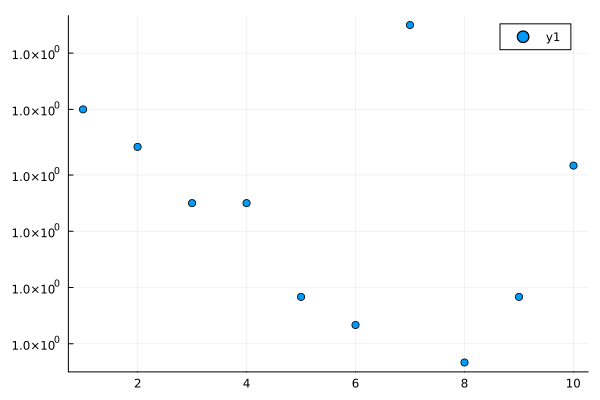

In [52]:
𝛹ₓₜ_norm=normalization_eigenstates_2D(𝛹ₓₜ,UHreim_1D,dΩ_1D);
scatter(𝛹ₓₜ_norm)

Resultado para la corrida usando `CoeffInitCond₁v₂Optimized(...)`

┌ Info: Saved animation to 
│   fn = /tmp/jl_IvWzUDaxWl.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_IvWzUDaxWl.gif")
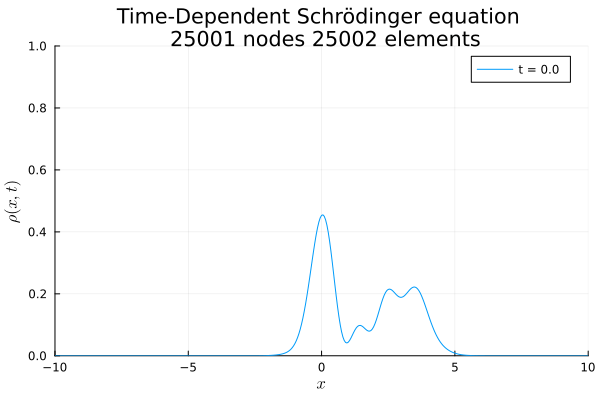

In [66]:
anim₁ = @animate for i in 1:1#length(time_vec)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    # plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot(x[:],ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-10,10))
end

gif(anim₁, fps = 1)

Resultado para la corrida usando `CoeffInitCond₁v₂Optimizedv₅(...)`

┌ Info: Saved animation to 
│   fn = /tmp/jl_wNCTOBmDqn.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_wNCTOBmDqn.gif")
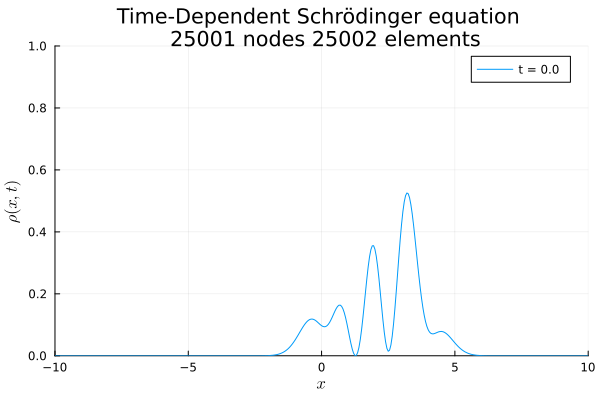

In [35]:
anim₁ = @animate for i in 1:1#length(time_vec)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    # plot(x[:],ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-10,10))
end

gif(anim₁, fps = 1)

Resultado para la corrida usando `CoeffInitCond₁v₂Optimizedv₆(...)`

┌ Info: Saved animation to 
│   fn = /tmp/jl_GDWheV8hmj.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_GDWheV8hmj.gif")
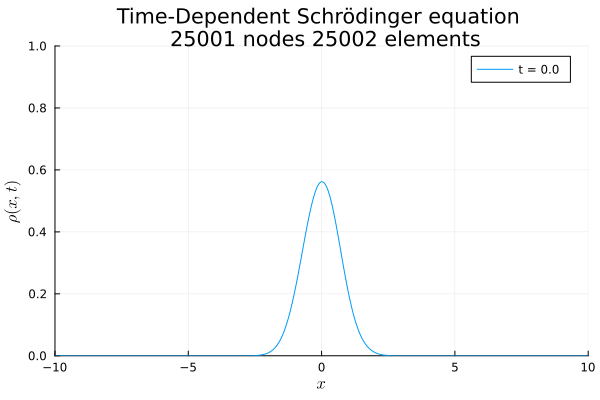

In [53]:
anim₁ = @animate for i in 1:10#length(time_vec)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    # plot(x[:],ρ₁Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-10,10))
end

gif(anim₁, fps = 1)